# FifaSkill

A Probabalistic Programming Package for European Soccer Analysis by Vinay Ramesh (vrr2112) and Alek Anchowski (aja2173)


In [1]:
from fifaskill.data_processing import process
from fifaskill.models import regression
import numpy as np
import pandas as pd
import sqlite3

from IPython.display import display

/Users/vramesh/Google Drive/University/Sem7/Prob Prog/trueskill_augmented/trueskill_env/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


## Introduction

Trueskill, developed by Microsoft Research, is a general skill based ranking system based upon a prior distribution around a player's mean skill and variance (Herbrich, Minka, Graepel). The original system models an player's skill, variance in performance, and uses an Expectation Propogation algorithm to update a player's skill representation and variance for every new game that the player participates in.

In our project fifaskill, we attempt to extend the Trueskill method to FIFA games, with the aim of modeling a team's overall skill and predicting future matches. We adapt from Trueskill methods because Expectation Propagation and message passing algorithms are not ideally implemented in edward. We experiment with modeling offense and defense skills seperately, as well as home team advantage.

Our package can be installed by running `pip install .` after navigating to the first fifaskill directory.

## Data

We will start in the middle of Box's loop for an overview of the data. We use the [Kaggle Dataset for European Soccer Matches](https://www.kaggle.com/hugomathien/soccer) 
which consists of a list of matches in 11 leagues and 8 seasons. We are interested in predicting outcomes of future matches using this given data. Because Champions League data is not present in this dataset, we evaluate leagues one at a time rather than jointly as we had originally hoped. The query we will use is focused on the English Premier League but can be trivially modified to any other country league by specifying the country in the query.   

A [Kaggle Notebook by Ashirwad](https://www.kaggle.com/ashirwadsangwan/competitiveness-in-the-european-leagues/notebook) noted the parity was highest in the English Premier League within the given dataset which makes this particular league the most challenging. We draw the below image from his notebook analysis to demonstrate this fact.  

![alt text](https://github.com/vinoo999/trueskill_augmented/raw/master/final_project/images/competitiveness.png)


In [2]:
# Now we load our EPL Data
db = '../database.sqlite'
query_fname = '../db_queries/detailed_match_query.sql'

conn = sqlite3.connect(db)

q_file = open(query_fname, 'r')
data = pd.read_sql(q_file.read(), conn)

data.head(2)

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,1730,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Arsenal,West Bromwich Albion,1,0
1,1731,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Sunderland,Liverpool,0,1


Below we partition our data to get ready for training with our models.

In [3]:
train, test = process.partition_data(data, by_season=True)

display(train.head(3))
display(test.head(3))

,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
0,1730,England,England Premier League,2008/2009,1,2008-08-16 00:00:00,Arsenal,West Bromwich Albion,1,0
258,1917,England,England Premier League,2008/2009,26,2009-02-23 00:00:00,Hull City,Tottenham Hotspur,1,2
257,1915,England,England Premier League,2008/2009,26,2009-02-22 00:00:00,Fulham,West Bromwich Albion,2,0


,id,country_name,league_name,season,stage,date,home_team,away_team,home_team_goal,away_team_goal
2912,4573,England,England Premier League,2015/2016,26,2016-02-13 00:00:00,Crystal Palace,Watford,1,2
2913,4574,England,England Premier League,2015/2016,26,2016-02-13 00:00:00,Everton,West Bromwich Albion,0,1
2914,4576,England,England Premier League,2015/2016,26,2016-02-13 00:00:00,Norwich City,West Ham United,2,2


## Model

### Basic from Trueskill

To model a team's performance, we assume a Gaussian prior, where the prior on skill $s_i$ is 
$$
\begin{align*}
  p(\mathbf{s_i})
  &\sim
  \text{Normal}( 25, \frac{25}{3} ^ 2)
\end{align*}
$$

When learning parameters we expect that the true skill $s_i^*$ be reflected as the mean of the performance distribution above.

Given two team's performances, $s_1$ and $s_2$, we then model the game's outcome, $r$, which we define to be the difference of the goals scored by each team against one another $\textbf{1}[s_1 - s_2] > 0$

In the model, this corrosponds to drawing from a Poisson distribution where the rate is the performance of the team. 

$$
\begin{align*}
    r &= \textbf{1}[\mathcal{P}(s^*_1) - \mathcal{P}(s^*_2) > 0]
\end{align*}
$$

To train the model, given $n$ teams, we obtain a matrix $R^{n, n}$ from the database, where an entry $R[team1, team2]$ would corrospond to the average difference of the goals scored by team1 against team2 and goals scored by team2 against team1. R is skew-symmetric, meaning $R^T = -R$, or more specifically that $R[team1, team2] == -R[team2, team1]$.

Our original implementation also shown below proved to converge poorly. As such this model can be translated into a simple Bayesian Linear Regression model. 

Here, our input data $X$ is a $m\times n$ matrix where there are $m$ matches and $n$ teams. Each match is represented as a two-hot vector where an entry is 1 if the team is home, -1 if the team is away, 0 otherwise. Our weight matrix $W \sim \mathcal{N}(25, \frac{25}{3} ^ 2)$ is a $d \times 1$ matrix denoting the skill of each team. Thus $XW$ outputs $Y$, a $m$ dimensional vector denoting the difference in skill levels of the two teams. Our supervised approach uses $Y$ as the goal differences for that particular match.

![alt text](https://github.com/vinoo999/trueskill_augmented/raw/master/final_project/images/Bayesian_Linear_Regression.png)

In [4]:
from fifaskill.models import regression
from fifaskill.models import basic
tsr = regression.TrueSkillRegressor(train, n_iter=10000)

/Users/vramesh/Google Drive/University/Sem7/Prob Prog/trueskill_augmented/trueskill_env/lib/python3.7/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


10000/10000 [100%] ██████████████████████████████ Elapsed: 11s | Loss: 6289.782


### Offense Defense Separation

To extend the basic model we seperate the team's skill into two scores, offense $s_{io}$ and defense $s_{id}$, where each is also defined with a Gaussian prior. Each team also has a variable offense and defense performance, based off the corrosponding skill, similar to how skill and performance were related in the basic model. We further now make the assertion that since we are modeling a discrete variable - goals - that we will use a Poisson distribution to model the goals scored. Based on the offense and defense performance, we draw from a Poisson distribution twice to determine the number of goals scored and number of goals allowed. We center the Gaussian prior to the standard normal in order to better account for a goals scored/allowed prior.

$$
\begin{align*}
s_{io} &\sim \mathcal{N}(0,1)\\
s_{id} &\sim \mathcal{N}(0,1)\\
s_i^* &\sim \mathcal{P}(s_{io}-s_{jd})\\
s_j^* &\sim \mathcal{P}(s_{jo}-s_{id})\\
r &\sim \mathbf{1}[s_i^* - s_j^* > 0]
\end{align*}
$$

We again reduce this to a Bayesian regression model by having one $W_o$ vector and one $W_i$ vector. This is in effect the composition of two log-linear models. Theoretically, this creates a compound Poisson regression model which can be modeled with a simple log-linear model however $y$ (goal difference) can take on negative values so we exponentiate it. We show both cases and will evaluate accordingly.

![alt text](https://github.com/vinoo999/trueskill_augmented/raw/master/final_project/images/Bayesian_Log_Linear_Model.png)
![alt text](https://github.com/vinoo999/trueskill_augmented/blob/master/final_project/images/Bayesian_Compound_Log_Linear.png?raw=true)

In [5]:
off_def = regression.LogLinearOffDef(train, n_iter=10000)
log_lin = regression.LogLinear(train, n_iter=10000)

10000/10000 [100%] ██████████████████████████████ Elapsed: 16s | Loss: 8126.843
10000/10000 [100%] ██████████████████████████████ Elapsed: 10s | Loss: 76560.234


## Inference

In the definitions of the models above, our classes inadvertently run inference. We use a factorized variational distribution in all cases. We used the Reparamaterization Score Gradient [even though it is the default for the `KLqp` function] explicitly it has a smaller variance than the normal Score Gradient.

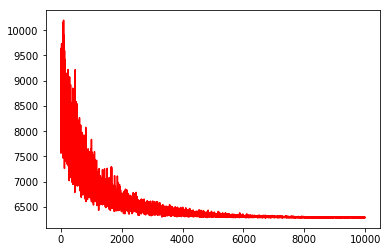

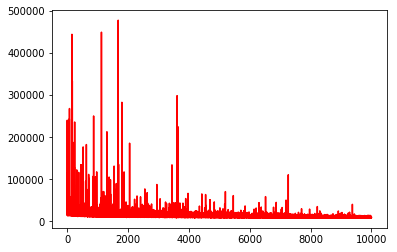

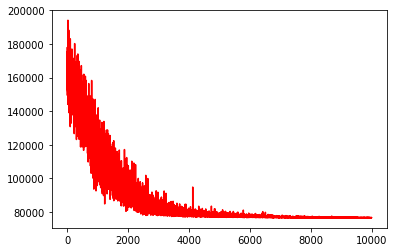

In [6]:
from fifaskill.data_processing import visualization
%matplotlib inline
visualization.plot_loss(tsr)
visualization.plot_loss(off_def)
visualization.plot_loss(log_lin)

This last model uses a TrueSkill python package that used expectation propagation as cited in the paper. We wrapped it to better serve our project. 

In [7]:
from fifaskill.models import trueskill_model
tsm = trueskill_model.TrueskillModel(train)

## Model Evaluation and Criticism

Firstly we provide the true skill-ordered rankings of the models

In [8]:
tsr_results = process.rankings_from_skills(tsr.team_skill, tsr.team_num_map)
offdef_results = process.rankings_from_skills(off_def.team_skill[0] - off_def.team_skill[1], off_def.team_num_map)
loglin_results = process.rankings_from_skills(log_lin.team_skill, log_lin.team_num_map)
tsm_results = process.rankings_from_skills(tsm.team_skills, tsm.team_num_map)

season_results = process.rankings(test)
data_dict = {}
data_dict['real_data'] = pd.Series(season_results.index.values)
data_dict['tsr'] = pd.Series(tsr_results.index.values)
data_dict['offdef'] = pd.Series(offdef_results.index.values)
data_dict['loglin'] = pd.Series(loglin_results.index.values)
data_dict['tsm'] = pd.Series(tsm_results.index.values)

display(pd.DataFrame(data_dict))

,real_data,tsr,offdef,loglin,tsm
0,Leicester City,Chelsea,Chelsea,Chelsea,Chelsea
1,Arsenal,Manchester United,Manchester United,Southampton,Manchester City
2,Tottenham Hotspur,Manchester City,Manchester City,Manchester City,Manchester United
3,Manchester City,Arsenal,Arsenal,Tottenham Hotspur,Arsenal
4,Manchester United,Liverpool,Liverpool,Manchester United,Tottenham Hotspur
5,Southampton,Tottenham Hotspur,Tottenham Hotspur,Liverpool,Liverpool
6,West Ham United,Everton,Everton,Arsenal,Everton
7,Liverpool,Southampton,Southampton,Leicester City,Southampton
8,Stoke City,Swansea City,Swansea City,Everton,Swansea City
9,Chelsea,Leicester City,Leicester City,Crystal Palace,Stoke City


Here we simulate the season and compare the ranking results for the 4 models

In [9]:
tsr_results = tsr.simulate(test)
tsr_record = process.gen_records(test.reset_index(drop=True), tsr_results)
offdef_results = off_def.simulate(test.reset_index(drop=True))
offdef_record = process.gen_records(test.reset_index(drop=True), offdef_results)
loglin_results = log_lin.simulate(test.reset_index(drop=True))
loglin_record = process.gen_records(test.reset_index(drop=True), loglin_results)
season_record = process.rankings(test.reset_index(drop=True))
# tsm_results = tsm.simulate(test)


data_dict = {}
data_dict['real_data_points'] = pd.Series(season_record['points'], index=season_record.index.values)
data_dict['tsr_points'] = pd.Series(tsr_record['points'], index=tsr_record.index.values)
data_dict['offdef_points'] = pd.Series(offdef_record['points'], index=offdef_record.index.values)
data_dict['loglin'] = pd.Series(loglin_record['points'], index=loglin_record.index.values)

record_chart = pd.DataFrame(data_dict)
record_chart



AttributeError: 'DataFrame' object has no attribute 'itertuple'

Lastly we look at the Posterior Predictive Checks to check resemblance to the underlying distribution of goals. We see that the models do not seem to represent the true distribution well.

To evaluate our model's prediction for the offense and defense scores for each team, we test them against the true values as defined by our dataset. For offense, we take an average of the chance creation scores of a team across several seasons, and for defense we average the defense pressure and aggression scores. For future work, it might be useful to determine whether our choice to combine these particular scores exactly corrosponds to a pure offense/defense skill level - perhaps there is a more complex relationship between pressure and aggression for example that would corrospond to higher defense scores.

In [13]:
query_fname = '../db_queries/off_def.sql'

q_file = open(query_fname, 'r')

off_def = pd.read_sql(q_file.read(), conn)
off_def['offense'] = off_def[['pass', 'cross', 'shoot']].mean(axis=1)
off_def['defense'] = off_def[['pressure', 'aggression']].mean(axis=1)
off_def = off_def[['team_name', 'offense','defense']]

In [14]:
off_def.head(5)

,team_name,offense,defense
0,Arsenal,42.500000,48.500000
1,Aston Villa,52.722222,42.750000
2,Birmingham City,58.777778,48.750000
3,Blackburn Rovers,51.666667,50.333333
4,Blackpool,58.833333,49.250000


Next, we compare these scores to our predicted values

### Criticism/ Model Revision

As we have explained earlier, our original conception of the model greatly changed because the model became trapped in a local optima, which resulted in the adaptation of varying regression models. 

In [15]:
# Next Steps